# Overlaying collider and Direct Detection Dark Matter constraints: an example notebook

In this notebook, we will overlay different constraints on a vector-mediated dark matter simplified model [1] from future colliders and direct detection experiments.
TODO: to be self consistent, we need to include in this cell
* Feynman diagram
* Sketch of DD
* Mention of dijet/monojet
* Mention of fixed vs varied couplings
* ESCAPE and the Dark Matter Science Project / the Virtual Research Environment
* iDMEu

Assorted imports, including a helper script to collect and display direct detection curves

In [4]:
%%capture
import numpy as np
from shapely.geometry import Polygon as shapely_pol
import pickle
from basic_plotter import *
import ROOT
import itertools as it
import sys, os
sys.path.insert(1, '../inputs/directdetection')
import collect_dd

import warnings
warnings.filterwarnings('ignore')

We will test a few couplings of the mediator to quarks (gq), leptons (gl) and dark matter (test_gdm), for the static version of the plots. The choice of these couplings does not change direct detection results, but they change the sensitivity of the collider results as they influence both production and decay of the mediator in a collider.    

In [11]:
gq = 0.25
test_gdm = [1.0,0.2,0.1,0.05]
gl = 0.01

These two functions are used to convert benchmark points that are constrained in collider space, identified by the couplings, the mediator mass and the DM mass, into benchmark points in the direct detection space of the nucleon-DM spin-dependent and spin-independent cross-section (equation 4.10 and 4.3 of [2]). 
Note: these conversion formulas do not include effects due to the difference in energy scales of the two experiments [3], but they do not change the picture for the purpose of these plots. 

In [12]:
# eqn 4.10 https://arxiv.org/pdf/1603.04156.pdf#page12
def calculate_sd(gq, gdm, gl, mMed, mdm) :

    mn = 0.939 # GeV
    val = 2.4e-42 * (gq*gdm/0.25)**2 * (1000./mMed)**4 * (mn*mdm/(mn+mdm))**2
    return val

# eqn 4.3: https://arxiv.org/pdf/1603.04156.pdf#page12
def calculate_si(gq, gdm, gl, mMed, mdm) :

    mn = 0.939 # GeV
    val = 6.9e-41 * (gq*gdm/0.25)**2 * (1000./mMed)**4 * (mn*mdm/(mn+mdm))**2
    return val

Some more helper functions (TODO: move outside this notebook at some point...)

In [13]:
def interpolate_vertical(x1,y1,x2,y2,n) :
    ov = sorted([[y1,x1],[y2,x2]])
    new_ys = np.linspace(ov[0][0], ov[1][0], num=n)
    new_xs = np.interp(new_ys,[ov[0][0],ov[1][0]],[ov[0][1],ov[1][1]])
    vertices = list(zip(new_xs,new_ys))
    return vertices if y1 < y2 else list(reversed(vertices))

In [14]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

Here we pick up the different constraints in terms of direct detection DM-nucleon interactions, spin-dependent for proton and neutron separately and spin-independent, and have a helper function that associates legends to curves. 

In [15]:
sd_proton = collect_dd.get_sd_proton()
sd_neutron = collect_dd.get_sd_neutron()
spin_independent = collect_dd.get_spin_independent()

In [16]:
# Collect direct detection contours for comparison plots.
def get_dd_lines(lineinfo) :
    legend_lines = list(lineinfo.keys())
    dd_lines = []
    for name in legend_lines :
        dd_lines.append(lineinfo[name])
    return legend_lines, dd_lines

This function takes care of the plotting given inputs in terms of collider name, kind of model (vector or axial vector mediator), contour lines, legend lines, and what couplings are fixed. 

In [17]:
def make_plots(collider, model, contours, legend_lines, fix_couplings, extra_tag = "") :
    xlow = 1
    xhigh = 2000 if 'hl-lhc' in collider else 4000
    if 'vector' in model : ylow = 1e-48 if 'hl-lhc' in collider else 1e-50
    else : ylow = 1e-46 if 'hl-lhc' in collider else 1e-50
    yhigh = 1e-37 if 'hl-lhc' in collider else 1e-42    
    usepath = "plots/directdetection/"+collider
    formatters = {"gq" : "q", "gdm" : "\chi", "gl" : "l"}
    treat_as_scaling = False
    # At least 2 fixed couplings.
    if len(fix_couplings.keys()) > 2 :
        label_line =  "{0}\n{7}, g$_{5}$={2}\ng$_{4}$={1}, g$_{6}$={3}".format(("Axial-vector" if 'axial' in model else "Vector"),fix_couplings["gq"],fix_couplings["gdm"],fix_couplings["gl"],"q","\chi","l",collider.upper())
        tag_line = model+"_gq{0}_gdm{1}_gl{2}".format(fix_couplings["gq"],fix_couplings["gdm"],fix_couplings["gl"])
    else :
        treat_as_scaling = True
        usecouplings = list(fix_couplings.keys())
        useformats = []
        vals = []
        for coupling in usecouplings :
            useformats.append(formatters[coupling])
            vals.append(fix_couplings[coupling])
        label_line = "{0}, {5}\ng$_{3}$={1}, g$_{4}$={2}".format(("Axial-vector" if 'axial' in model else "Vector"),vals[0],vals[1],useformats[0],useformats[1],collider.upper())
        tag_line = model+"_{0}{1}_{2}{3}".format(usecouplings[0],vals[0],usecouplings[1],vals[1])
    if extra_tag : tag_line = tag_line + "_" + extra_tag
    # And draw. First, version without DD experiment lines
    # Then draw the plots with DD lines on
    if 'vector' in model :
        # If doing fcc-hh, remove MIGD line which is too high up to be seen.
        formatted_lines = get_dd_lines(spin_independent)
        ddcurves = []
        ddnames = []
        for name, line in zip(formatted_lines[0],formatted_lines[1]) :
            if not ('fcc' in collider and 'MIGD' in name) :
                ddcurves.append(line)
                ddnames.append(name)
        use_ylabel = "$\sigma_{SI}$ ($\chi$-nucleon) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line, plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh)
        drawDDPlot(contours,legend_lines, this_tag = tag_line+"_withDD", plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh, dd_curves = ddcurves, dd_legendlines = ddnames)
    else :
        use_ylabel = "$\sigma_{SD}$ ($\chi$-nucleon) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line, plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh)
        formatted_lines_p = get_dd_lines(sd_proton)
        use_ylabel = "$\sigma_{SD}$ ($\chi$-proton) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line+"_withDD_proton", plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh, dd_curves = formatted_lines_p[1], dd_legendlines = formatted_lines_p[0])  
        formatted_lines_n = get_dd_lines(sd_neutron)
        use_ylabel = "$\sigma_{SD}$ ($\chi$-neutron) [cm$^2$]"
        drawDDPlot(contours,legend_lines, this_tag = tag_line+"_withDD_neutron", plot_path = usepath, addText = label_line, ylabel=use_ylabel, is_scaling=treat_as_scaling, transluscent=treat_as_scaling, xhigh=xhigh, ylow=ylow, yhigh=yhigh, dd_curves = formatted_lines_n[1], dd_legendlines = formatted_lines_n[0])

Here we load all the files including polygons for the HL-LHC vector mediated DM benchmark models, and make different grids of plots with different options using python dictionaries. 

In [18]:
# Load pickle files with polygons
# Limits with fixed couplings
with open('{0}_exclusion_contours_{1}.pkl'.format('vector','hl-lhc'), "rb") as poly_file:
    loaded_polygons = pickle.load(poly_file)
    
    # Grid of plots:
    exclusions_dd = {'dijet' : {}}
    exclusions_separate_dd = {'dijet' : {}}

    # And now third set of plots with gq and gl fixed:
    contours_list_couplingscan = []
    legend_lines_couplingscan = []
    for gdm in test_gdm :
        contours_list = []
        # e.g. no coupling to leptons, skip:
        if (gq, gdm, gl) not in exclusions_dd['dijet'].keys() :
            continue                            
        exclusions = exclusions_dd['dijet'][(gq, gdm, gl)]
        contours_list+=exclusions
        if all(not i for i in contours_list) : continue
        full_polygons = merge_exclusions(contours_list)
        contours_list_couplingscan.append(full_polygons)
        legend_lines_couplingscan.append("g$_{0}$={1}".format("\chi",gdm))
    make_plots('hl-lhc', 'vector', contours_list_couplingscan, legend_lines_couplingscan, {"gq" : gq, "gl" : gl})
    # A version overlaying all monojet and overlaying all dijet, but not combining
    sub_contours_list = []
    sub_legends_list = []
    for gdm in test_gdm :
        if (gq, gdm, gl) not in exclusions_separate_dd['dijet'].keys() : continue
        sub_contours_list.append(exclusions_separate_dd['dijet'][(gq, gdm, gl)])
        sub_legends_list.append("g$_{0}$={1}".format("\chi",gdm))                   
    make_plots('hl-lhc', 'vector', sub_contours_list,sub_legends_list, {"gq" : gq, "gl" : gl}, extra_tag = 'dijet')

Imports, input and output directories

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

FULL_SPECTRA_PATH = "data/Full_spectra"  # arXiv:[2109.03116]
OUTPUT_FOLDER = "plots"

Here we plot the Darkside example plot. WIP Leo: overlaying the HL-LHC plots and future colliders as well. 

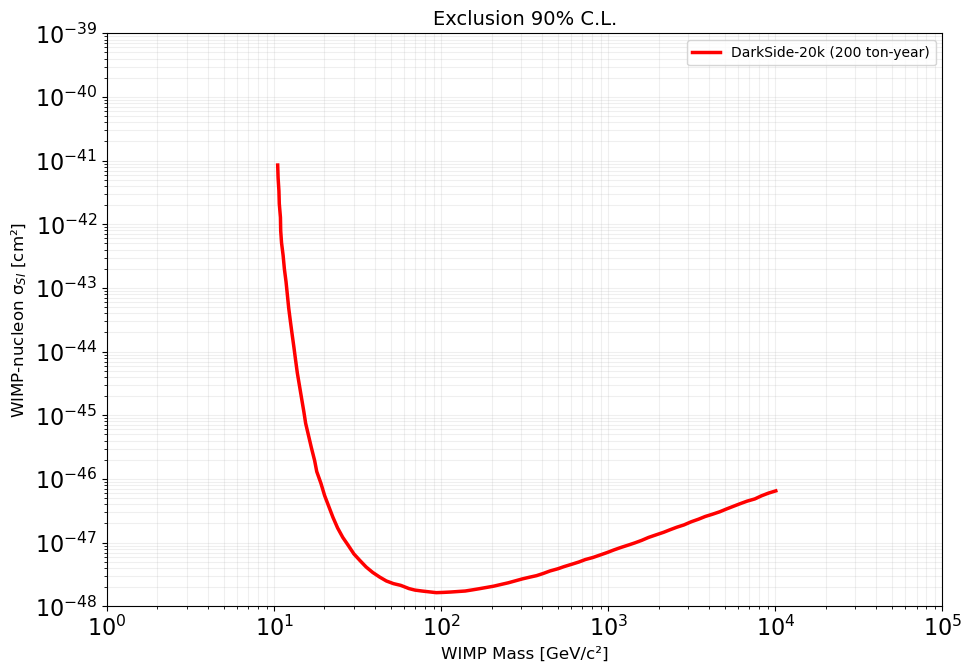

In [22]:
plt.figure(figsize=(10, 7))

# Define filenames for the full spectra
DS200TY_FULL_SPECTRUM_FILE = "DarkSide-200ty.txt"  # DS-20k 200 ton-year projection

# Load DarkSide-200ty full spectrum
try:
    # First try with comma delimiter
    try:
        ds200ty_mass, ds200ty_xsec = np.loadtxt(os.path.join(FULL_SPECTRA_PATH, DS200TY_FULL_SPECTRUM_FILE), 
                                          delimiter=',', unpack=True)
    except:
        # If comma fails, try tab delimiter
        ds200ty_mass, ds200ty_xsec = np.loadtxt(os.path.join(FULL_SPECTRA_PATH, DS200TY_FULL_SPECTRUM_FILE), 
                                          delimiter='\t', unpack=True)
    
    # Plot DS-200ty data
    plt.loglog(ds200ty_mass, ds200ty_xsec, '-', color='red', linewidth=2.5, 
             label='DarkSide-20k (200 ton-year)')
except Exception as e:
    print(f"Error loading DarkSide-200ty full spectrum: {e}")

# Set plot properties
plt.xlabel('WIMP Mass [GeV/c²]', fontsize=12)
plt.ylabel('WIMP-nucleon σ$_{SI}$ [cm²]', fontsize=12)
plt.title('Exclusion 90% C.L.', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(fontsize=10)

# Set axis limitsm
plt.xlim(1, 100000)  
plt.ylim(1e-48, 1e-39) 

# Save plot
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "full_spectra_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

References:

[1] A. Boveia et al., Dark Matter Benchmark Models for Early LHC Run-2 Searches: Report of the ATLAS/CMS Dark Matter Forum, https://doi.org/10.1016/j.dark.2019.100371 

[2] https://arxiv.org/pdf/1603.04156#page12

[3] https://arxiv.org/abs/1411.3342
